## Modules à importer

In [6]:
import math
import scipy
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from sklearn.cluster import KMeans
from variaIa.variaIa import baserate
from variaIa.variaIa import stretchevol
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions (et sélection de l'échantillon à utiliser)

In [10]:
d = pd.read_csv('../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SDSS', 'SNLS', 'PS1', 'HST', 'SNF']

su = ipw.Dropdown(options=surveys,
                  description='Survey:',
                  value = 'SNF')

surv = {'SDSS': d[d['IDSURVEY'] == 1],
        'SNLS': d[d['IDSURVEY'] == 4],
        'PS1':  d[d['IDSURVEY'] == 15],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])],
        'SNF':  d_snf}

# .loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)]

colors = {'SDSS': 'lime',
          'SNLS': 'red',
          'PS1': 'blue',
          'HST': 'purple',
          'SNF': 'orange'}

zmax = {'SDSS': 0.22,
        'SNLS': 0.70,
        'PS1': 0.33,
        'HST': 10,
        'SNF': 10}

#def set_data(su):
#    global ns_dataz, dataz, ns_datax, datax
#    if su == 'SNF':
#        ns_dataz = surv[su]['host.zcmb'].values
#        dataz = np.sort(ns_dataz)
#        ns_datax = surv[su]['salt2.X1'].values
#        datax = np.sort(ns_datax)
#    else:
#        ns_dataz = surv[su].zCMB.values
#        dataz = np.sort(ns_dataz)
#        ns_datax = surv[su].x1.values
#        datax = np.sort(ns_datax)
#    
#int_data = ipw.interactive(set_data, su = su)
#display(int_data)

## Choix des bins pour les listes de redshifts et de strech

In [7]:
nb_z = ipw.IntSlider(min = 3, max = 30, value = 12, description='#bins for z:', continuous_update=False)

def set_bins_z(nb_z):
    global binsz, bordz, countsz
    bordz = np.asarray(np.histogram(dataz, bins = nb_z)[1])
    binsz = np.asarray([[bordz[i],bordz[i+1]] for i in range(len(bordz)-1)]).T
    countsz = np.histogram(dataz, bordz)[0]
    
int_bins_z = ipw.interactive(set_bins_z, nb_z = nb_z)
display(int_bins_z)

nb_x = ipw.IntSlider(min = 3, max = 30, value = 12, description='#bins for x:', continuous_update=False)

def set_bins_x(nb_x):
    global binsx, bordx, countsx
    bordx = np.asarray(np.histogram(datax, bins = nb_x)[1])
    binsx = np.asarray([[bordx[i],bordx[i+1]] for i in range(len(bordx)-1)]).T
    countsx = np.histogram(datax, bordx)[0]
    
int_bins_x = ipw.interactive(set_bins_x, nb_x = nb_x)
display(int_bins_x)

interactive(children=(IntSlider(value=12, continuous_update=False, description='#bins for z:', max=30, min=3),…

interactive(children=(IntSlider(value=12, continuous_update=False, description='#bins for x:', max=30, min=3),…

## Définitions des dictionnaires : $z < z_{\text{max}}$ cuts pour $z$ et $x_1$ + total

In [11]:
zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()
x1_err_zcuts = dict()

for survey in surveys[:-1]:
    zmax_cuts[survey] = np.where(surv[survey].zCMB.values < zmax[survey])
    z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
    x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
    x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    
zmax_cuts['SNF'] = np.where(surv['SNF']['host.zcmb'].values < zmax['SNF'])
z_zcuts['SNF'] = surv['SNF']['host.zcmb'].values[zmax_cuts['SNF']]
x1_zcuts['SNF'] = surv['SNF']['salt2.X1'].values[zmax_cuts['SNF']]
x1_err_zcuts['SNF'] = surv['SNF']['salt2.X1.err'].values[zmax_cuts['SNF']]

datax_comp = np.concatenate((np.concatenate((np.concatenate((np.concatenate((x1_zcuts['SNF'],
                                                                             x1_zcuts['SDSS'])),
                                                             x1_zcuts['SNLS'])),
                                             x1_zcuts['PS1'])),
                             x1_zcuts['HST']))

datax_err_comp = np.concatenate((np.concatenate((np.concatenate((np.concatenate((x1_err_zcuts['SNF'],
                                                                                 x1_err_zcuts['SDSS'])),
                                                                 x1_err_zcuts['SNLS'])),
                                                 x1_err_zcuts['PS1'])),
                                 x1_err_zcuts['HST']))

dataz_comp = np.concatenate((np.concatenate((np.concatenate((np.concatenate((z_zcuts['SNF'],
                                                                             z_zcuts['SDSS'])),
                                                             z_zcuts['SNLS'])),
                                             z_zcuts['PS1'])),
                             z_zcuts['HST']))

## Utilisation de la classe _stretchevol_ pour le fit double

FCN = 349.98606987751134 
 TOTAL NCALL = 302 
 NCALLS = 302 
 
 
 EDM = 6.877755300956294e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,a,0.477301,0.0739106,,,0,1,No
1,mu_1,0.386896,0.0674781,,,,,No
2,sigma_1,-0.555105,0.0542969,,,,,No
3,mu_2,-1.52109,0.11653,,,,,No
4,sigma_2,-0.518584,0.0900309,,,,,No


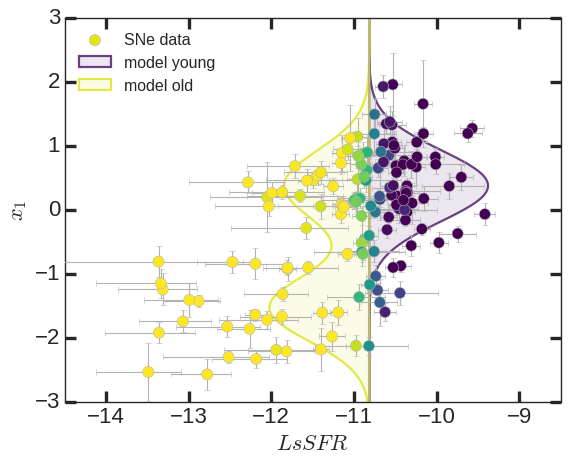

In [8]:
reload(stretchevol)

names = {'lssfr_name':       'lssfr',
         'stretch_name':     'salt2.X1',
         'stretch_err_name': 'salt2.X1.err',
         'lssfr_err_d_name': 'lssfr.err_down',
         'lssfr_err_u_name': 'lssfr.err_up',
         'py_name':          'p(prompt)'}

evolD = stretchevol.EvolDouble()
evolD.set_names(names)
evolD.set_data(d_snf)

evolD.minimize()

evolD.scatter()

#fig=plt.gcf()
#fig.savefig('/home/nora/Pictures/BiGaussian.pdf')

FCN = 350.08766138734427 
 TOTAL NCALL = 200 
 NCALLS = 200 
 
 
 EDM = 1.0172653840718018e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,a,0.468423,0.0686118,,,0,1,No
1,mu_1,0.392891,0.0634225,,,,,No
2,sigma_1,-0.54545,0.0432381,,,,,No
3,mu_2,-1.50461,0.109101,,,,,No


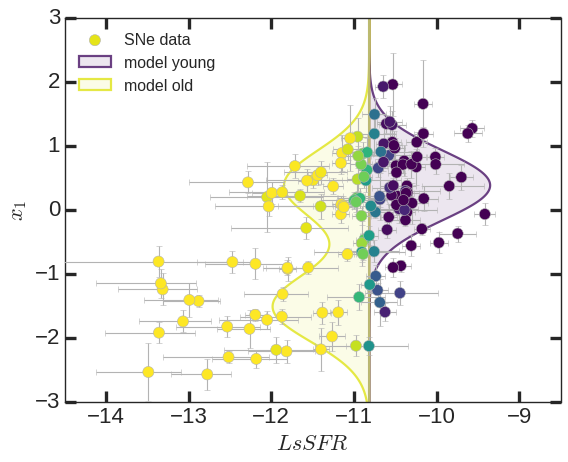

In [63]:
reload(stretchevol)

names = {'lssfr_name':       'lssfr',
         'stretch_name':     'salt2.X1',
         'stretch_err_name': 'salt2.X1.err',
         'lssfr_err_d_name': 'lssfr.err_down',
         'lssfr_err_u_name': 'lssfr.err_up',
         'py_name':          'p(prompt)'}

evolDS = stretchevol.EvolDoubleSigma()
evolDS.set_names(names)
evolDS.set_data(d_snf)

evolDS.minimize()

evolDS.scatter()

#fig=plt.gcf()
#fig.savefig('/home/nora/Pictures/BiGaussian.pdf')

In [18]:
def gauss(x, dx, mu, sigma):
    return scipy.stats.norm.pdf(x, mu, scale=np.sqrt(dx**2+sigma**2))

def delta(z):
    '''Gives the fraction of young SNe Ia as a function of redshift;
    taken from https://arxiv.org/abs/1806.03849'''
    K = 0.87
    Phi = 2.8
    return (K**(-1)*(1+z)**(-Phi)+1)**(-1)

def psi(z):
    '''Gives the fraction of old SNe Ia as a function of redshift;
    taken from https://arxiv.org/abs/1806.03849'''
    K = 0.87
    Phi = 2.8
    return (K*(1+z)**(Phi)+1)**(-1)

def likelihood_oS(x, dx, a, mu_1, sigma_1, mu_2):
    '''La fonction décrivant le modèle des SNe vieilles'''
    return a*gauss(x, dx, mu_1, sigma_1) \
     + (1-a)*gauss(x, dx, mu_2, sigma_1)

def likelihood_yS(x, dx, mu_1, sigma_1):
    '''La fonction décrivant le modèle des SNe jeunes'''
    return gauss(x, dx, mu_1, sigma_1)

def likelihood_totS(z, x, dx, a, mu_1, sigma_1, mu_2):
    '''La fonction prenant en compte la probabilité d'être vieille/jeune'''
    return delta(z)*likelihood_yS(x, dx, mu_1, sigma_1) \
     + (1-delta(z))*likelihood_oS(x, dx, a, mu_1, sigma_1, mu_2)

logLS = 0
for i in range(len(dataz_comp)):
    logLS += np.log(likelihood_totS(dataz_comp[i], datax_comp[i], datax_err_comp[i],
                                  evolDS.param['a'],
                                  evolDS.param['mu_1'], evolDS.param['sigma_1'],
                                  evolDS.param['mu_2']))
    
-2*np.sum(logLS)

1836.7758114574608

In [68]:
def loglikelihoodS(a, mu_1, sigma_1, mu_2):
    return -2*np.sum(np.log(likelihood_totS(dataz_comp, datax_comp, datax_err_comp,
                                          a, mu_1, sigma_1, mu_2)))

def logpriorS():
    ''' '''
    return 0
                                                                           
def logprobS(a, mu_1, sigma_1, mu_2):
    ''' '''
    loglikelihood_ = loglikelihoodS(a, mu_1, sigma_1, mu_2)
    logprior_ = logpriorS()
    return logprior_ + loglikelihood_


m_totalS = im.Minuit(logprobS, limit_a=(0,1),
                     mu_1 = evolDS.param['mu_1'], sigma_1 = evolDS.param['sigma_1'],
                     mu_2 = evolDS.param['mu_2'],
                     fix_mu_1 = False, fix_sigma_1 = False,
                     fix_mu_2 = False,
                     print_level=1, pedantic=False)

m_totalS.migrad();

FCN = 1814.733594891301 
 TOTAL NCALL = 107 
 NCALLS = 107 
 
 
 EDM = 2.4812367064741238e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,a,0.465495,0.0733789,,,0,1,No
1,mu_1,0.351892,0.0428082,,,,,No
2,sigma_1,-0.606835,0.0283448,,,,,No
3,mu_2,-1.25075,0.0969968,,,,,No


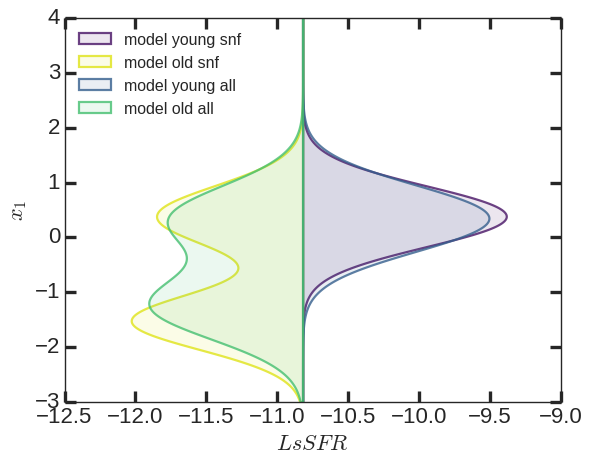

In [69]:
lssfr_med = -10.82

x_linspace = np.linspace(-3, 4, 3000)

plt.fill_betweenx(x_linspace,
                  2*likelihood_y(x_linspace, 0,
                                 evolD.param['mu_1'],
                                 evolD.param['sigma_1'])
                  + lssfr_med,
                  lssfr_med,
                  facecolor=plt.cm.viridis(0.05, 0.1),
                  edgecolor=plt.cm.viridis(0.05, 0.8),
                  lw=2, label='model young snf')
                                                              
plt.fill_betweenx(x_linspace,
                  -3*likelihood_o(x_linspace, 0,
                                       evolD.param['a'],
                                       evolD.param['mu_1'],
                                       evolD.param['sigma_1'],
                                       evolD.param['mu_2'],
                                       evolD.param['sigma_2'])
                  + lssfr_med,
                  lssfr_med,
                  facecolor=plt.cm.viridis(0.95, 0.1),
                  edgecolor=plt.cm.viridis(0.95, 0.8),
                  lw=2, label='model old snf')

plt.fill_betweenx(x_linspace,
                  2*likelihood_yS(x_linspace, 0,
                                 m_totalS.values['mu_1'],
                                 m_totalS.values['sigma_1'])
                  + lssfr_med,
                  lssfr_med,
                  facecolor=plt.cm.viridis(0.30, 0.1),
                  edgecolor=plt.cm.viridis(0.30, 0.8),
                  lw=2, label='model young all')
                                                              
plt.fill_betweenx(x_linspace,
                  -3*likelihood_oS(x_linspace, 0,
                                       m_totalS.values['a'],
                                       m_totalS.values['mu_1'],
                                       m_totalS.values['sigma_1'],
                                       m_totalS.values['mu_2'])
                  + lssfr_med,
                  lssfr_med,
                  facecolor=plt.cm.viridis(0.70, 0.1),
                  edgecolor=plt.cm.viridis(0.70, 0.8),
                  lw=2, label='model old all')

ax = plt.gca()
                                     
ax.tick_params(axis='both',
               direction='in',
               length=10, width=3,
               labelsize=20,
               which='both',
               top=True, right=True)

plt.xlabel('$LsSFR$', fontsize=20)
plt.ylabel('$x_1$', fontsize=20)

plt.legend(ncol=1, loc='upper left')

## Utilisation du BIC pour comparaison des modèles

In [1]:
def get_bic(logl, k, n):
    return -2*logl + k*np.log(n)

def get_aicc(logl, k, n):
    return 2*k - 2*logl + (2*k*(k+1))/(n - k - 1)

In [15]:
get_bic(logL, 5, len(dataz_comp))

1868.274408332625

In [19]:
get_bic(logLS, 4, len(dataz_comp))

1862.9167765415154

In [58]:
print('AICc(BBC) = ', get_aicc(-.5*out[0]['fval'], 3, len(datax_comp)))
print('AICc(NR_res) = ', get_aicc(logLS, 4, len(dataz_comp)))
print('Delta AICc = ', get_aicc(-.5*out[0]['fval'], 3, len(datax_comp)) - get_aicc(logLS, 4, len(dataz_comp)))

AICc(BBC) =  1937.6321877556318
AICc(NR_res) =  1844.8342909896246
Delta AICc =  92.79789676600717


In [59]:
np.exp(-92.8/2)

7.058883911899183e-21

In [60]:
scipy.stats.norm.pdf(5, loc = 0, scale = 1)

1.4867195147342979e-06

In [80]:
BIC_age = -2*logLS + 4*np.log(len(dataz_comp))
BIC_BBC = -2*logLB + 2*np.log(len(dataz_comp))
print('chi²_age = ', -2*np.sum(logLS), '; BIC_age = ', BIC_age)
print('chi²_BBC = ', -2*np.sum(logLB), '; BIC_BBC = ', BIC_BBC)

chi²_age =  1836.7758114574608 ; BIC_age =  1862.9167765415154
chi²_BBC =  3287.6371928621425 ; BIC_BBC =  3300.7076754041695


In [53]:
get_bic(-.5*out[0]['fval'], 3, len(datax_comp))

1951.2028750723223

## Utilisation de _stretchevol_ pour le _mock_

In [68]:
reload(stretchevol)

mockD = stretchevol.MockEvol()

mockD.set_values(evolD.param)
mockD.set_data(0.05, 1000)

mockD.solver()
#mockD.plotter(50, [-3,3])

## Définition des dictionnaires généraux : mean et std

In [10]:
z_mean = dict()
z_std = dict()
x1_mean = dict()
x1_std = dict()

for survey in surveys:
    z_mean[survey] = np.mean(z_zcuts[survey])
    z_std[survey] = np.std(z_zcuts[survey])
    x1_mean[survey] = np.mean(x1_zcuts[survey])
    x1_std[survey] = np.std(x1_zcuts[survey])

## Utilisation du _mock_ sur large bande de redshifts

In [13]:
def get_stretch_sample(redshift, npoints, shuffle=True):
    mock = stretchevol.MockEvol()
    mock.set_values(evolD.param)
    mock.set_data(redshift, npoints)
    mock.solver()
    mockx = np.concatenate((mock.x1_o,mock.x1_y))
    if shuffle:
        np.random.shuffle(mockx)
    return mockx

In [14]:
zz = np.linspace(0, 1.4, 200)
x1_z = np.asarray([get_stretch_sample(z_, 100000) for z_ in zz])

low_x1 = np.asarray([len(x_[x_<-.5])/len(x_) for x_ in x1_z])

## Détermination loi analytique

In [15]:
def mock_law(z, a, b):
    return a*mockD.delta(z) + b

def mock_law_min(a, b):
    return np.sqrt(np.sum((mock_law(zz, a, b) - np.mean(x1_z, axis=1))**2))

m_mock = im.Minuit(mock_law_min,
                   b = -0.6, a = 1,
                   print_level=1, pedantic=False)

m_mock.migrad();

FCN = 0.024398179978462463 
 TOTAL NCALL = 46 
 NCALLS = 46 
 
 
 EDM = 2.3445120605570867e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,a,0.995806,0.123827,,,,,No
1,b,-0.609263,0.0951593,,,,,No


## Tracé des $x_{\text{mean}}$ en fonction des $z_{\text{mean}}$ + _mock_

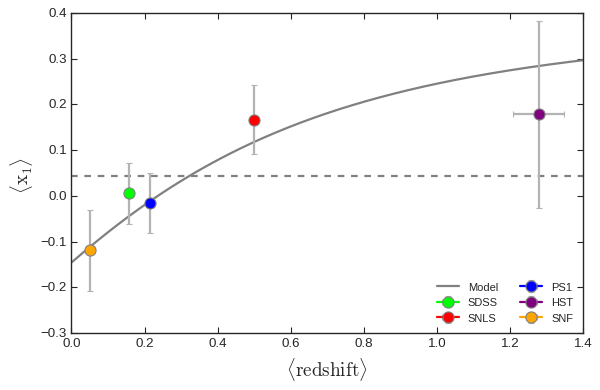

In [16]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])


prop = dict(marker="o", ms=10, ecolor="0.7", lw=2, mew=1, mec="0.5", zorder=5)
for i in range(5):
#    if i != 4:
#        continue
    ax.errorbar(list(z_mean.values())[i], list(x1_mean.values())[i],
                 xerr = list(z_std.values())[i]/np.sqrt(len(list(z_zcuts.values())[i])),
                 yerr = list(x1_std.values())[i]/np.sqrt(len(list(x1_zcuts.values())[i])), 
                 color = list(colors.values())[i], label = surveys[i], **prop)

    
#ax.plot(zz, np.mean(x1_z, axis=1), color="0.7", zorder=2, label="BiGaussianModel")
ax.axhline( np.mean(list(x1_mean.values()) ), lw=2, ls="--", color="0.5")

ax.plot(zz, mock_law(zz, m_mock.values['a'], m_mock.values['b']),
        color="0.5", lw=2, label='Model')

ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 12,
               top = True, right = True)

ax.set_xlabel(r"$\langle\mathrm{redshift} \rangle$ ", fontsize="x-large")
ax.set_ylabel(r"$\langle\mathrm{x}_1 \rangle$ ", fontsize="x-large")

#ax.set_ylim(-0.3, 0.4)

ax.legend(loc="lower right", ncol=2, fontsize="small")

#fig.savefig('/home/nora/Pictures/stretchevol_onlysnf.pdf')

## Calcul du $\chi²$

In [81]:
chi2_hline = 0
for i in range(5):
    chi2_hline += (list(x1_mean.values())[i] - np.mean(np.asarray(list(x1_mean.values()))))**2\
                    / (list(x1_std.values())[i]/np.sqrt(len(list(x1_zcuts.values())[i])))**2
    
chi2_model = 0
for i in range(5):
    chi2_model += (list(x1_mean.values())[i] - mock_law(np.asarray(list(z_mean.values())[i]),
                                                          m_mock.values['a'],
                                                          m_mock.values['b']))**2\
                    / (list(x1_std.values())[i]/np.sqrt(len(list(x1_zcuts.values())[i])))**2

delta_chi2 = chi2_hline - chi2_model

display(Latex("$\chi²_{\mathrm{hline}}$ = %5f " % chi2_hline))
display(Latex("$\chi²_{\mathrm{model}}$ = %5f " % chi2_model))
display(Latex("$\Delta\chi²$ = %5f " % delta_chi2))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Moyennage sur toutes les données pour plus de points

### Définition des bins sur lesquels faire les moyennes

In [12]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

n, bins, patches = plt.hist(dataz_comp, histedges_equalN(dataz_comp, 6))
plt.close()

NameError: name 'zz_all' is not defined

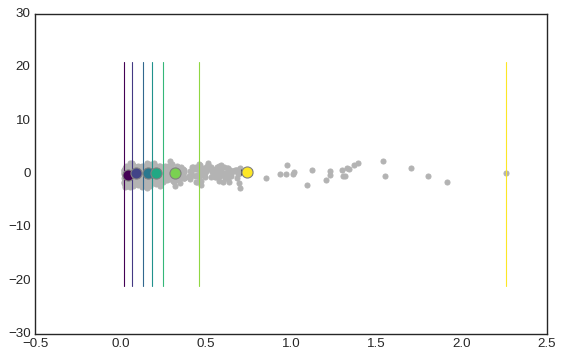

In [13]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop = dict(marker="o", ms=10, ecolor="0.3", lw=2, mew=1, mec="0.5", zorder=5)

ax.scatter(dataz_comp, datax_comp, color="0.7")

vmap_v = plt.cm.viridis(np.linspace(0, 1, len(bins)))
for i in range(len(bins)):
    ax.vline(bins[i], color = vmap_v[i])

slices = []
x1_comp_mean = np.zeros(6)
x1_comp_std = np.zeros(6)
z_comp_mean = np.zeros(6)
z_comp_std = np.zeros(6)

for i in range(6):
    slices.append(np.where((dataz_comp > bins[i]) & (dataz_comp <= bins[i+1])))
    x1_comp_mean[i] = np.mean(datax_comp[slices[i]])
    x1_comp_std[i] = np.std(datax_comp[slices[i]])
    z_comp_mean[i] = np.mean(dataz_comp[slices[i]])
    z_comp_std[i] = np.std(dataz_comp[slices[i]])
    
vmap_s = plt.cm.viridis(np.linspace(0, 1, 6))
for i, c in zip(range(6), vmap_s):
   ax.errorbar(z_comp_mean[i], x1_comp_mean[i],
               xerr = z_comp_std[i]/np.sqrt(len(dataz_comp[slices[i]])),
               yerr = x1_comp_std[i]/np.sqrt(len(dataz_comp[slices[i]])),
               color=vmap_s[i], **prop)

zlin = np.linspace(0, 2.65, 1000)

#ax.plot(zz, np.mean(x1_z, axis=1), color="0.7", zorder=2, label="BiGaussianModel")
ax.plot(zz_all, np.mean(x1_z_all, axis=1), color="0.7", zorder=2, label="Age model all")

ax.plot(zlin, mock_law(zlin, m_mock.values['a'], m_mock.values['b']),
        color="0.5", lw=2, label='Age Model SNF')

ax.plot(zlin, psi(zlin)-0.3,
       color="0.5", lw=2, label='$\psi(z)$')

ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 12,
               top = True, right = True)

ax.set_xlabel(r"$\langle\mathrm{redshift} \rangle$ ", fontsize="x-large")
ax.set_ylabel(r"$\langle\mathrm{x}_1 \rangle$ ", fontsize="x-large")

plt.legend(ncol=1, loc='center right')

#ax.set_ylim(-3, 3)
ax.set_ylim(-0.3, 0.4)
ax.set_xlim(0.01, 2.65)
#ax.set_xscale('log')

In [14]:
def gauss(x, dx, mu, sigma):
    return scipy.stats.norm.pdf(x, mu, scale=np.sqrt(dx**2+sigma**2))

def delta(z):
    '''Gives the fraction of young SNe Ia as a function of redshift;
    taken from https://arxiv.org/abs/1806.03849'''
    K = 0.87
    Phi = 2.8
    return (K**(-1)*(1+z)**(-Phi)+1)**(-1)

def psi(z):
    '''Gives the fraction of old SNe Ia as a function of redshift;
    taken from https://arxiv.org/abs/1806.03849'''
    K = 0.87
    Phi = 2.8
    return (K*(1+z)**(Phi)+1)**(-1)

def likelihood_o(x, dx, a, mu_1, sigma_1, mu_2, sigma_2):
    '''La fonction décrivant le modèle des SNe vieilles'''
    return a*gauss(x, dx, mu_1, sigma_1) \
     + (1-a)*gauss(x, dx, mu_2, sigma_2)

def likelihood_y(x, dx, mu_1, sigma_1):
    '''La fonction décrivant le modèle des SNe jeunes'''
    return gauss(x, dx, mu_1, sigma_1)

def likelihood_tot(z, x, dx, a, mu_1, sigma_1, mu_2, sigma_2):
    '''La fonction prenant en compte la probabilité d'être vieille/jeune'''
    return delta(z)*likelihood_y(x, dx, mu_1, sigma_1) \
     + (1-delta(z))*likelihood_o(x, dx, a, mu_1, sigma_1, mu_2, sigma_2)

logL = 0
for i in range(len(dataz_comp)):
    logL += np.log(likelihood_tot(dataz_comp[i], datax_comp[i], datax_err_comp[i],
                                  evolD.param['a'],
                                  evolD.param['mu_1'], evolD.param['sigma_1'],
                                  evolD.param['mu_2'], evolD.param['sigma_2']))
    
-2*np.sum(logL)

1835.5982019775568

In [61]:
def loglikelihood(a, mu_1, sigma_1, mu_2, sigma_2):
    return -2*np.sum(np.log(likelihood_tot(dataz_comp, datax_comp, datax_err_comp,
                                          a, mu_1, sigma_1, mu_2, sigma_2)))

def logprior(a, mu_1, sigma_1, mu_2, sigma_2, use_prior = False):
    ''' '''
    if use_prior is False:
        return 0
    prior_sigma = scipy.stats.norm.pdf(sigma_1-sigma_2, loc=0, scale=1e-3)
    if prior_sigma == 0:
        return -1e14
    return np.log(prior_sigma)
                                                                           
def logprob(a, mu_1, sigma_1, mu_2, sigma_2):
    ''' '''
    loglikelihood_ = loglikelihood(a, mu_1, sigma_1, mu_2, sigma_2)
    logprior_ = logprior(a, mu_1, sigma_1, mu_2, sigma_2, use_prior = True)
    return logprior_ + loglikelihood_


m_total = im.Minuit(logprob, limit_a=(0,1),
                    mu_1 = evolD.param['mu_1'], sigma_1 = evolD.param['sigma_1'],
                    mu_2 = evolD.param['mu_2'], sigma_2 = evolD.param['sigma_2'],
                    fix_mu_1 = False, fix_sigma_1 = False,
                    fix_mu_2 = False, fix_sigma_2 = False,
                    print_level=0, pedantic=False)

m_total.migrad();

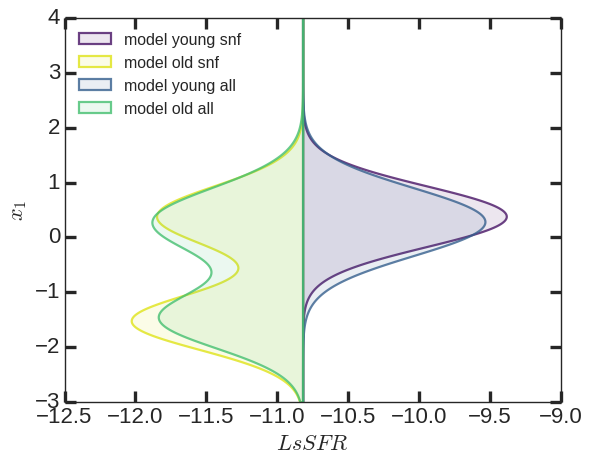

In [62]:
lssfr_med = -10.82

x_linspace = np.linspace(-3, 4, 3000)

plt.fill_betweenx(x_linspace,
                  2*likelihood_y(x_linspace, 0,
                                 evolD.param['mu_1'],
                                 evolD.param['sigma_1'])
                  + lssfr_med,
                  lssfr_med,
                  facecolor=plt.cm.viridis(0.05, 0.1),
                  edgecolor=plt.cm.viridis(0.05, 0.8),
                  lw=2, label='model young snf')
                                                              
plt.fill_betweenx(x_linspace,
                  -3*likelihood_o(x_linspace, 0,
                                       evolD.param['a'],
                                       evolD.param['mu_1'],
                                       evolD.param['sigma_1'],
                                       evolD.param['mu_2'],
                                       evolD.param['sigma_2'])
                  + lssfr_med,
                  lssfr_med,
                  facecolor=plt.cm.viridis(0.95, 0.1),
                  edgecolor=plt.cm.viridis(0.95, 0.8),
                  lw=2, label='model old snf')

plt.fill_betweenx(x_linspace,
                  2*likelihood_y(x_linspace, 0,
                                 m_total.values['mu_1'],
                                 m_total.values['sigma_1'])
                  + lssfr_med,
                  lssfr_med,
                  facecolor=plt.cm.viridis(0.30, 0.1),
                  edgecolor=plt.cm.viridis(0.30, 0.8),
                  lw=2, label='model young all')
                                                              
plt.fill_betweenx(x_linspace,
                  -3*likelihood_o(x_linspace, 0,
                                       m_total.values['a'],
                                       m_total.values['mu_1'],
                                       m_total.values['sigma_1'],
                                       m_total.values['mu_2'],
                                       m_total.values['sigma_2'])
                  + lssfr_med,
                  lssfr_med,
                  facecolor=plt.cm.viridis(0.70, 0.1),
                  edgecolor=plt.cm.viridis(0.70, 0.8),
                  lw=2, label='model old all')

ax = plt.gca()
                                     
ax.tick_params(axis='both',
               direction='in',
               length=10, width=3,
               labelsize=20,
               which='both',
               top=True, right=True)

plt.xlabel('$LsSFR$', fontsize=20)
plt.ylabel('$x_1$', fontsize=20)

plt.legend(ncol=1, loc='upper left')

In [23]:
dict_param = {'a':      m_total.values['a'],
             'mu_1':    m_total.values['mu_1'],
             'sigma_1': m_total.values['sigma_1'],
             'mu_2':    m_total.values['mu_2'],
             'sigma_2': m_total.values['sigma_2']}

def get_stretch_sample_all(redshift, npoints, shuffle=True):
    mock = stretchevol.MockEvol()
    mock.set_values(dict_param)
    mock.set_data(redshift, npoints)
    mock.solver()
    mockx = np.concatenate((mock.x1_o,mock.x1_y))
    if shuffle:
        np.random.shuffle(mockx)
    return mockx

In [24]:
zz_all = np.linspace(0, 2.6, 500)
x1_z_all = np.asarray([get_stretch_sample_all(z_, 100000) for z_ in zz_all])

In [49]:
x1_mean_tot = np.mean(datax_comp)

sigma_m_g = 1.472
sigma_p_g = 0.222

def BBC_prob(x, dx, mu, sigma_m, sigma_p):
    flag_up = x >= mu
    l = np.zeros(len(x))
    
    l[flag_up] = gauss(x[flag_up], dx[flag_up], mu, sigma_p)
    l[~flag_up] = gauss(x[~flag_up], dx[~flag_up], mu, sigma_m)
    return l

def BBC_to_minimize(mu, sigma_m, sigma_p):
    likelihood = BBC_prob(datax_comp, datax_err_comp, mu, sigma_m, sigma_p)
    return -2*np.sum(np.log(likelihood))

m_bbc = im.Minuit(BBC_to_minimize,
                  mu = 0.973,
                  sigma_p = 0.318869, sigma_m = 1.40826,
                  print_level=1, pedantic=False)

out = m_bbc.migrad()


FCN = 1931.5971512592814 
 TOTAL NCALL = 163 
 NCALLS = 163 
 
 
 EDM = 2.6655547999158874e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,mu,0.608698,6.46364e-06,,,,,No
1,sigma_m,1.25313,0.0425139,,,,,No
2,sigma_p,0.444299,0.0285816,,,,,No


In [53]:
get_bic(-.5*out[0]['fval'], 3, len(datax_comp))

1951.2028750723223

In [52]:
out[0]['fval']

1931.5971512592814